In [ ]:
"""****************************Imports****************************"""
import socket; import time; import pandas as pd
from keithley_base.keithley_connect import *
from keithley_base.keithley_setup import *
from keithley_base.functions import *
import serial


"""****************************Functions****************************"""
def PrintCommand(ser, command):
  # encode text to ascii
  ser.write(str.encode(command)) 

  # check for the final read out
  while True:
    line = ser.readline()
    if line == b'ok\n' or line == b'ok \n' or line == b'':
      break

def EPICFinder(s, ser, stepSize):
    # begin data collection
    InstrumentWrite(s,"INIT")
    time.sleep(0.25)
    print('Termination Criteria, Laser Displacement')

    while True:
        bufferSize = int(InstrumentQuery(s, "TRACe:ACTual? \"Sensing\"", 16).rstrip())
        
        # let the buffer get to 200 data points. if the buffer isn't large enough, pass
        if bufferSize <= 200:
            pass    
        elif bufferSize > 200:
                time.sleep(0.2)
                # read the buffer value and the average
                buffer = float(InstrumentQuery(s, f"TRACe:DATA? {bufferSize}, {bufferSize}, \"Sensing\", READ", 16).split(',')[0])
                bufferAverage = float(InstrumentQuery(s, "TRACe:STATistics:AVERage? \"Sensing\"", 16))
                print(np.round(bufferAverage, 6), buffer)
                
                # termination is when the laser displacement sees variance above the average. at termination, the actuator
                # moves back one step. future steps are cut in half. this is occurs two times before reaching zero. 
                if np.abs(bufferAverage - buffer) <= 0.1:
                    PrintCommand(ser, f'G1 F200 Z{stepSize} \n')
                else:
                    PrintCommand(ser, f'G1 F200 Z{-stepSize} \n')
                    break

    InstrumentWrite(s,"ABORT")


"""****************************Device connnection****************************"""
# define the instrament's IP address. the port is 5025 for LAN connection.
ipAddress = "169.254.253.110"
myPort = 5025

# establish connection to the LAN socket. initialize and connect to the Keithley
s = socket.socket()                 # Establish a TCP/IP socket object
InstrumentConnect(s, ipAddress, myPort, 10000)

# connect to the 3d printer
ser = serial.Serial('COM6', 115200, timeout = 1)
time.sleep(1)
PrintCommand(ser, "G28 Z \n")

# run the code until the program ends or ctr+C is hit.
try: 
    """***************Test parameters***************"""
    # input the gel type and its plasticizer content
    # print('List the gel type, plasticizer content, type, and % \n Ex: P8 XkV Xmm 5mL Xtrial')
    print('Input material parameters and objective for file name')
    Parameters = input('     ').upper()


    """***************Channel setup***************"""
    # list the channels used and initize the keithley. the you place these values is 
    # the order the columns will produce the excel sheet
    channels = '120' 

    # setup the channels
    KeithleySetup(s, channels)
    DcVoltSetup(s, channels)
    numberOfChannels = len(channels.split(','))

    # find the EPIC boundary. set the rail to relative position mode then move until we find the boundary.
    PrintCommand(ser,f'G91 \n')
    EPICFinder(s, ser, 0.5)
    PrintCommand(ser, f'G1 F200 Z-1 \n')
    EPICFinder(s, ser, 0.01)
    print("\n Begin Test \n")

    # begin data collection for at least 10 minutes
    InstrumentWrite(s,"INIT")
    time.sleep(0.025)

    # set the printer to absolute mode and zero the z axis. move the printer slowly back and forth
    speed = 200
    travel = 10
    PrintCommand(ser, "G90 \n")
    PrintCommand(ser, "G92 Z0 \n")
    PrintCommand(ser, f"G1 Z{travel} F{speed} \n")
    PrintCommand(ser, f"G1 Z0 F{speed} \n")
    PrintCommand(ser, f"G1 Z{travel} F{speed} \n")

except KeyboardInterrupt:
    """****************************Data export****************************"""
    Data = KeithleyStop(s, numberOfChannels)
    
    # export the data 
    df = pd.DataFrame(columns = ["Position (mm)", "Thickness (mm)"])

    # convert time to displacement. the rail moves at speed [mm/min] or speed/60 [mm/s]
    df["Position (mm)"] = Data[:, 0]*speed/60
    df["Thickness (mm)"] = 2.49982*Data[:, 1] - 2.39379 # laser displacement sensor calibration from V to mm

    df.to_csv(f"Data/{Parameters}.csv", sep = ',', header = True, index = False)
    print('\nTest finished')
    pass

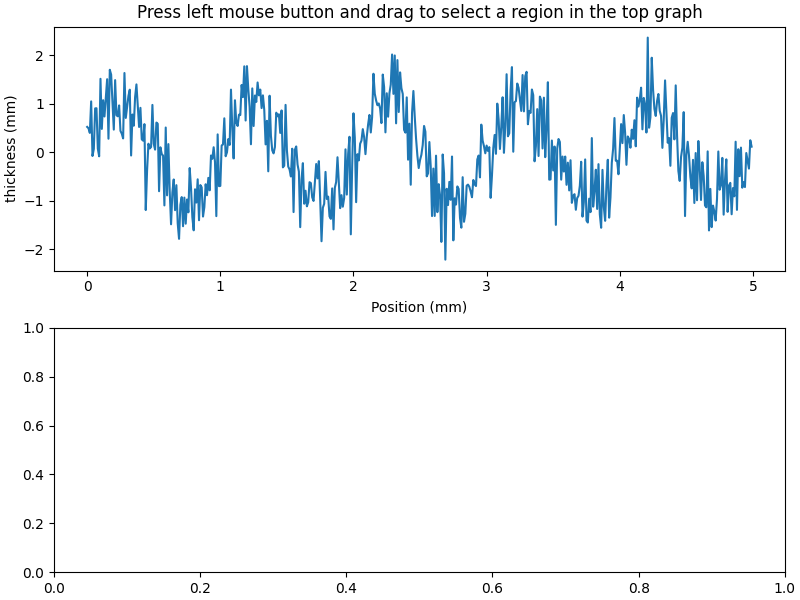

In [ ]:
"""Use this section to convert the data into the selection region for
   measuring the gel thickness and width"""

%matplotlib ipympl
import matplotlib.pyplot as plt; from matplotlib.widgets import SpanSelector
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

# preallocate the data plot
fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 6), layout = 'constrained')

x = np.arange(0.0, 5.0, 0.01)
y = np.sin(2 * np.pi * x) + 0.5 * np.random.randn(len(x))

# plot the data
# ax1.plot(data[:,0], data[:,1])
ax1.plot(x, y)

ax1.set_xlabel('Position (mm)')
ax1.set_ylabel('thickness (mm)')
ax1.set_title('Press left mouse button and drag '
              'to select a region in the top graph')


# define the selection region function
def Selection(xmin, xmax):
    # find the data regions desired
    minIndex, maxIndex = np.searchsorted(x, (xmin, xmax))
    maxIndex = min(len(x) - 1, maxIndex)

    # store the data regions, x is width and y is height
    xRegion = x[minIndex:maxIndex]
    yRegion = y[minIndex:maxIndex]

    # if two points are selected, plot the results
    if len(xRegion) >= 2:
        # calculate the average height from the data set
        averageheight = np.mean(yRegion)

        # store the average
        height.append(averageheight)

        # take the difference from the initial height (sheet 
        # under the gel) and the gel surface to get thickness
        # measure the width between the points
        sampleThickness = np.abs(averageheight - height[0])
        sampleWidth = np.abs(xRegion[-1]-xRegion[0])
                             
        # plot the thickness in the sample region
        ax2.plot(xRegion, sampleThickness*np.ones(len(yRegion)), label = f'Thickness: {np.round(sampleThickness,3)}, Width: {np.round(sampleWidth,3)}')
        ax2.plot(xRegion, yRegion)
        ax2.set_xlim(xRegion[0], xRegion[-1])
        ax2.set_ylim(yRegion.min(), yRegion.max())
        ax2.legend()
        fig.canvas.draw_idle()

height = []
span = SpanSelector(
    ax1,
    Selection,
    "horizontal",
    useblit = True,
    props = dict(alpha = 0.5, facecolor="tab:blue"),
    interactive = True,
    drag_from_anywhere = True,
)
